In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import string
import seaborn as sns

## Machine learning utilities 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

## Suppress future warning messages 

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load dataset 

In [4]:
d = pd.read_csv('train.csv',encoding='latin1');
f = pd.read_csv('test.csv',encoding='latin1');
dataset = pd.concat([d,f])

## Display basic dataset information 

In [5]:
print(dataset.shape)
print(dataset.info())
display(dataset.head())

(32296, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB
None


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Drop rows with missing values 

In [6]:
dataset.dropna(inplace=True)

## Visualize sentiment distribution 

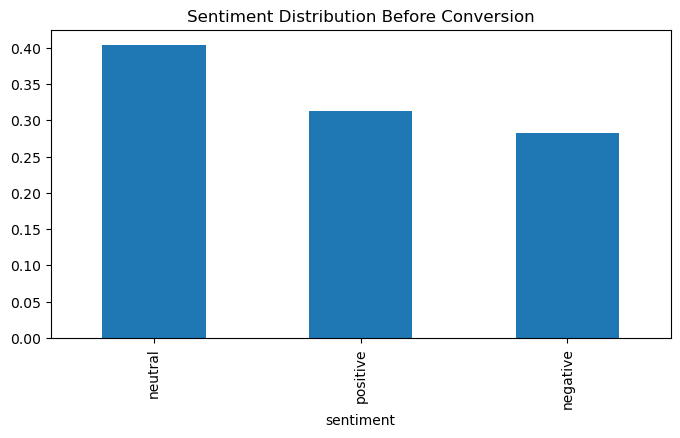

In [7]:
plt.figure(figsize=(8, 4))
dataset['sentiment'].value_counts(normalize=True).plot(kind='bar')
plt.title('Sentiment Distribution Before Conversion')
plt.show()

## Convert categorical variables 

In [8]:
dataset['sentiment'] = pd.Categorical(dataset['sentiment']).codes
dataset['Time of Tweet'] = pd.Categorical(dataset['Time of Tweet']).codes
dataset['Country'] = pd.Categorical(dataset['Country']).codes

## Age group conversion to numerical approximation 

In [9]:
age_mapping = {'0-20': 18, '21-30': 25, '31-45': 38, '46-60': 53, '60-70': 65, '70-100': 80}
dataset['Age of User'] = dataset['Age of User'].map(age_mapping)

## Age Distribution of Users

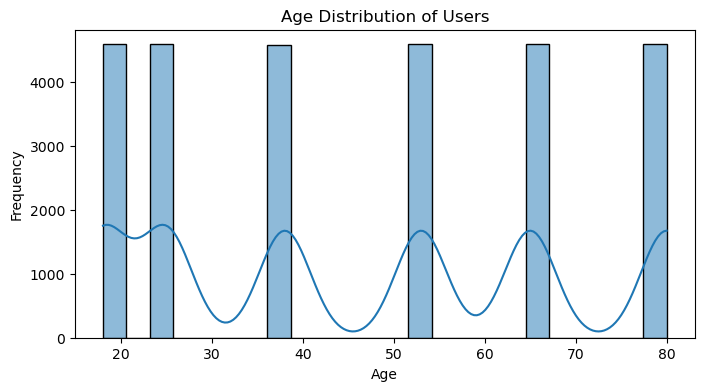

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(dataset['Age of User'], kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Visualize sentiment distribution after conversion 

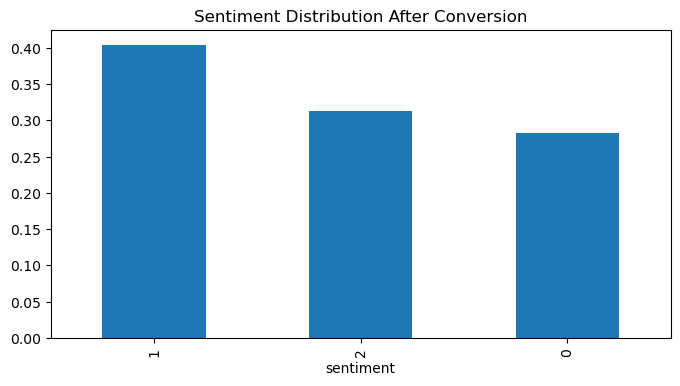

In [11]:
plt.figure(figsize=(8, 4))
dataset['sentiment'].value_counts(normalize=True).plot(kind='bar')
plt.title('Sentiment Distribution After Conversion')
plt.show()

## Drop irrelevant columns 

In [12]:
dataset_reduced = dataset.drop(columns=['textID', 'Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

## Preprocessing function for text data 

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\\W', " ", text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)    
    return text

## Apply text cleaning 

In [14]:
dataset_reduced['cleaned_text'] = dataset_reduced["selected_text"].apply(clean_text)

## Prepare data for modeling 

In [15]:
X = dataset_reduced['cleaned_text']
y = dataset_reduced['sentiment']

## Split dataset 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Text vectorization 

In [17]:
vectorizer = TfidfVectorizer()
XV_train = vectorizer.fit_transform(X_train)
XV_test = vectorizer.transform(X_test)

## Baseline accuracy 

In [18]:
baseline_accuracy = y.value_counts(normalize=True).max()

## Initialize and train models 

In [19]:
models = {
    "Logistic Regression": LogisticRegression(n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=0)
}
performance = []


## Function to evaluate models 

In [20]:
def evaluate_models(models, XV_train, y_train, XV_test, y_test):
    for name, model in models.items():
        model.fit(XV_train, y_train)
        predictions = model.predict(XV_test)
        accuracy = accuracy_score(y_test, predictions)
        performance.append(accuracy)
        print(f"{name} Accuracy: {accuracy}")
        print(classification_report(y_test, predictions))
        ConfusionMatrixDisplay.from_predictions(y_test, predictions)
        plt.title(f"{name} Confusion Matrix")
        plt.show()

## Evaluate models 

Logistic Regression Accuracy: 0.8286026200873362
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1572
           1       0.79      0.88      0.83      2236
           2       0.91      0.80      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.83      0.83      0.83      5496



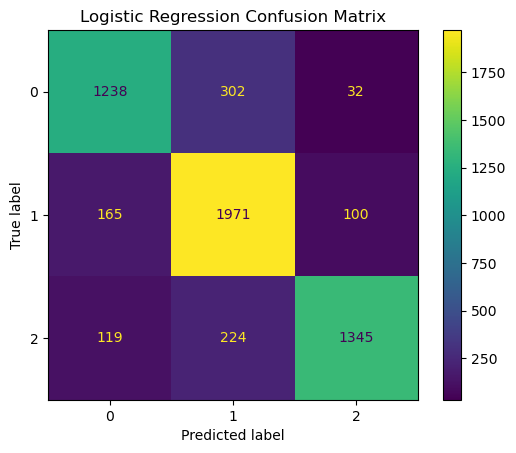

Decision Tree Accuracy: 0.759825327510917
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1572
           1       0.76      0.77      0.76      2236
           2       0.83      0.76      0.79      1688

    accuracy                           0.76      5496
   macro avg       0.76      0.76      0.76      5496
weighted avg       0.76      0.76      0.76      5496



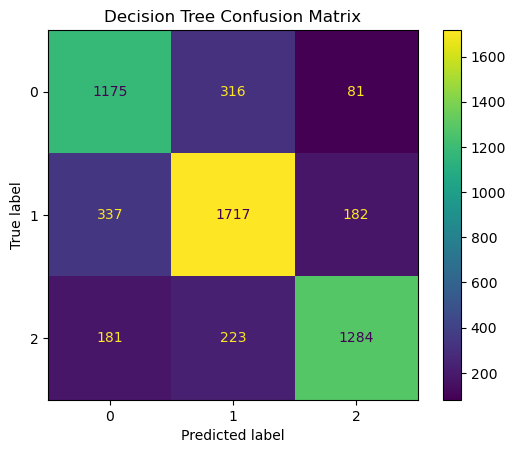

Random Forest Accuracy: 0.8116812227074236
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1572
           1       0.77      0.90      0.83      2236
           2       0.91      0.76      0.83      1688

    accuracy                           0.81      5496
   macro avg       0.82      0.80      0.81      5496
weighted avg       0.82      0.81      0.81      5496



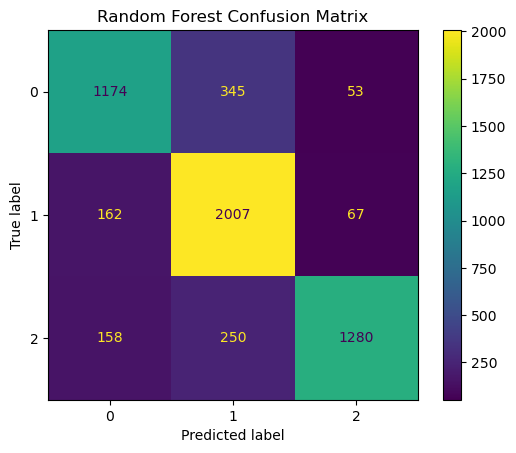

In [21]:
evaluate_models(models, XV_train, y_train, XV_test, y_test)

## Model Performance Comparison 

In [22]:
model_performance = {
    "Logistic Regression": performance[0],  
    "Decision Tree": performance[1],
    "Random Forest": performance[2]
}

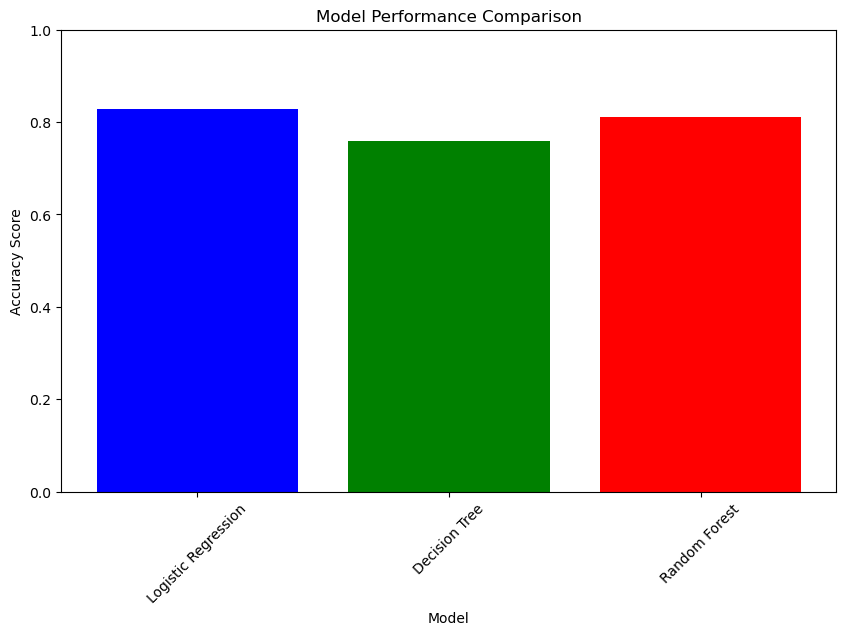

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(model_performance.keys(), model_performance.values(), color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

## Function for sentiment prediction 

In [24]:
def predict_sentiment(text):
    cleaned_text = clean_text(text)
    vectorized_text = vectorizer.transform([cleaned_text])
    predictions = {name: model.predict(vectorized_text)[0] for name, model in models.items()}
    for model_name, prediction in predictions.items():
        sentiment = "Negative" if prediction == 0 else "Neutral" if prediction == 1 else "Positive"
        print(f"{model_name}: {sentiment}")

## Example usage 

In [25]:
example_text = "I am Sad"
predict_sentiment(example_text)

Logistic Regression: Negative
Decision Tree: Negative
Random Forest: Negative
